# Deep Learning Tutorial

This tutorial is a stripped down version of the one provided at http://deeplearning.net/tutorial. It uses only Python, Numpy and Theano. We have omitted many important and technical details about learning with neural networks (eg. regularizers, early-stopping), so please have a look at the full version if you decide to continue with these things.

For more details about Theano, see http://deeplearning.net/software/theano/index.html.

## Part 1: Setting up the data

To learn, we need data. This notebook uses two basic datasets: a set of pictures of plates from the Rijksmuseum collection [1], and a set of portraits from the Humanae project [2]. We start by importing these images into two matrices, and showing how to display them.



In [2]:
# create interactive plots
% matplotlib notebook

import os, random, time, math
import theano as th
import theano.tensor as T
from PIL import Image, ImageOps
import IPython.display as disp
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from ipywidgets import widgets  

In [3]:
# Helper functions

# Clean up a plot
def clean():
    ax = plt.gca()
    ax.get_yaxis().set_tick_params(which='both', direction='out')

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().set_tick_params(which='both', top='off',)
    ax.get_yaxis().set_tick_params(which='both', right='off')

In [4]:
%%html # ignore this cell
<style>
.widget-area .btn { width: 80px; }   
</style>

Most of what we will do will be expressed as matrix operations, using the numpy package. we don't have time to go into the details, but just to get a sense of the syntax, here are some examples.

In [5]:
# create a matrix
matrix = np.asarray([[0.0, 1.0], [2.0, 3.0]])
print(matrix)
print()

# select a single entry (note, the indices start at 0)
print(matrix[0, 1])
print()

# select a whole row
print(matrix[0, :])
print()

# select a whole column
print(matrix[:, 0])
print()

# multiply everything by 0.5
matrix *= 0.5
print(matrix)
print()

# proper matrix multiplication
print(matrix.dot(matrix))
print()

[[ 0.  1.]
 [ 2.  3.]]

1.0

[ 0.  1.]

[ 0.  2.]

[[ 0.   0.5]
 [ 1.   1.5]]

[[ 0.5   0.75]
 [ 1.5   2.75]]



Test some basic image loading and display

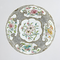

In [6]:
image = Image.open('./plates/0001134_AK-NM-13855.png')

vector = np.asarray(image) # load into 60 x 60 x 3 tensor
old_shape = vector.shape

vector = np.ravel(vector) / 255.0 # flatten into vector with [0,1] values (this is the form we'll feed to the network)

vector = vector.reshape(old_shape) # recover the three layers of the RGB image

image = Image.fromarray((vector * 255.0).astype('uint8'))

b = BytesIO() # Save the image to a byte array in memory
image.save(b, format='png')
disp.Image(b.getvalue()) # Display the image to the notebook


Let's load the _plates_ and _faces_ examples into memory.

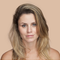

In [7]:
import glob

path_plates = './plates'
path_faces  = './faces'

# We'll load only the first 100 of each
num_instances = 2000 
num_features = np.ravel(vector).shape[0] # each channel of each pixel is a feature

# Load the images into a big matrix
plates = np.zeros((num_instances, num_features)) # matrix of zeros
faces = np.zeros((num_instances, num_features))

#i = 0
#for f in glob.glob(path_plates + '/*.png')[0:num_instances]:
#    vector = np.ravel(np.asarray(Image.open(f))) / 255.0 # Load the image as a flat vector
#    plates[i, :] = vector # set this image as the i'th row of the matrix
#    i += 1
    
i = 0
for f in glob.glob(path_faces + '/*.png')[0:num_instances]:
    vector = np.ravel(np.asarray(Image.open(f))) / 255.0 # Load the image as a flat vector
    faces[i, :] = vector # set this image as the i'th row of the matrix
    i += 1
    
# Combine into one big data matrix and a class vector

# data = np.concatenate((plates, faces), axis=0)
data = faces
# The classes
# ones = np.ones((num_instances, 1))
# clss = np.concatenate((ones, ones*-1.0), axis=0) # plate = 1.0, face = - 1.0
clss = np.ones((num_instances, 1))

# This is what the data looks like
# print(data)
# print(clss)
    
# Show a random face
vector = faces[random.randint(0, num_instances - 1), :]
vector = vector.reshape(old_shape) * 255.0 # unflatten
vector = vector.astype('uint8')    # convert to integers

image = Image.fromarray(vector)    # convert to image

# ... convert to notebook output
b = BytesIO() 
image.save(b, format='png')
disp.Image(b.getvalue()) 

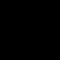

In [8]:
# Show a random plate
vector = plates[random.randint(0, num_instances - 1), :]
vector = vector.reshape(old_shape) * 255.0 # flatten
vector = vector.astype('uint8')    # convert to integers

image = Image.fromarray(vector)    # convert to image

# ... convert to notebook output
b = BytesIO() 
image.save(b, format='png')
disp.Image(b.getvalue()) 

Since testing your models on the training data is a _mortal sin_ in machine learning, we will also need some unseen data to see how well our models did:

In [9]:
# Load the images into a big matrix
plates_test = np.zeros((num_instances, num_features)) # matrix of zeros
faces_test = np.zeros((num_instances, num_features))


i = 0
for f in glob.glob(path_plates + '/*.png')[num_instances:2*num_instances]:
    vector = np.ravel(np.asarray(Image.open(f))) / 255.0 # Load the image as a flat vector
    plates_test[i, :] = vector # set this image as the i'th row of the matrix
    i += 1
    
i = 0
for f in glob.glob(path_faces + '/*.png')[num_instances:2*num_instances]:
    vector = np.ravel(np.asarray(Image.open(f))) / 255.0 # Load the image as a flat vector
    faces_test[i, :] = vector # set this image as the i'th row of the matrix
    i += 1
    
test_data = np.concatenate((plates_test, faces_test), axis=0)

Now that we have our data, let's look at some Theano code. Theano is a symbolic computing library: it allows you to represent algebraic functions symbolically first, and then compile them into functions. This allows us to switch to processing on the GPU down the line almost seamlessly. Here's a simple example of how it works:

In [10]:
a = T.scalar('a')
b = T.scalar('b')

# c is the symbolic representation of 'a * b'
c = a * b
print(th.pp(c))

# cf is the compiled version of c ...
cf = th.function([a, b], c)
print(cf)

# ... which we can call like any other function
print(cf(3, 8))

# We can also make the function change the state of some external variable,
# called a _shared_ variable

i = th.shared(value=0.0, name='i')
cf = th.function([a, b], c, updates=[(i, i + 1)])

print('cf has been called {} times'.format(i.get_value()))

print(cf(3, 8))
print(cf(3, 8))
print(cf(3, 8))

print('cf has been called {} times '.format(i.get_value()))


(a * b)
24.0
cf has been called 0.0 times
24.0
24.0
24.0
cf has been called 3.0 times 


## Part 2: The perceptron

Using Theano, we will reproduce (roughly) the first ever neural model: the _Perceptron_. First, we will try it on a simple 2D dataset, so we can illustrate what is happening.

Try playing around with the batch size and the learning rate, to see what effect they have on the convergence of the algorithm.

In [11]:
batch_size = 100
learning_rate = 0.1

# Sample some basic data (2000 points from two normal distributions)
num = 1000
data2d = np.concatenate((
    np.random.multivariate_normal([0.0, .5], np.identity(2)*0.1, num),
    np.random.multivariate_normal([0.0, -.5], np.identity(2)*0.1, num)))
ones = np.ones((num, 1))
clss2d = np.concatenate((ones, ones*-1.0))

# show the data
fig = plt.figure()
plt.scatter(data2d[:, 0], data2d[:, 1], c=clss2d, cmap=colors.ListedColormap(['blue', 'red']), linewidth=0)
clean()

# Now, let's construct our model

# Now we use theano to describe the model, the loss, and the gradients
x = T.matrix('x') # input

W = T.matrix('W') # weights
b = T.vector('b') # bias node
y_pred = T.tanh((T.dot(x, W) + b))
y_true = T.matrix('y_true')
loss = T.pow((y_pred - y_true), 2).sum() / batch_size

model = th.function([x, W, b], y_pred)
err   = th.function([x, W, b, y_true], loss)

W_values = np.asarray([[2.0], [1.0]])
b_value = np.asarray([1.0])

# Theano can take the derivatives with respect to W and b automatically
gradient_W = th.function([x, W, b, y_true], T.grad(cost=loss, wrt=W))
gradient_b = th.function([x, W, b, y_true], T.grad(cost=loss, wrt=b))

# Plot the line
line = (- b_value - W_values[0, 0] * data2d[:, 0]) / W_values[1, 0]
drawn_line, = fig.gca().plot(data2d[:, 0], line, 'g-')

# create a button
button = widgets.Button(description='100 steps', width=100)
disp.display(button)

# This happens when the button is pressed
def handle(sender):
    global W_values, b_value, drawn_line
    
    for i in range(100):

        # sample a subset of the data
        ix = np.random.randint(data2d.shape[0],size=batch_size)
        d = data2d[ix, 0:2] # sample_size random rows 
        c = clss2d[ix].reshape((batch_size, 1)) # the corresponding class labels

        # p = model(d, W_values, b_value)
        # e = err(d, W_values, b_value, c)
        
        # Compute the gradients at d
        gw = gradient_W(d, W_values, b_value, c)
        gb = gradient_b(d, W_values, b_value, c)

        # Update the model parameters 
        W_values -= learning_rate * gw
        b_value  -= learning_rate * gb

        # re-plot the line
        newline = (- b_value - W_values[0, 0] * data2d[:, 0]) / W_values[1, 0]
        drawn_line.set_ydata(newline)
        fig.canvas.draw()

button.on_click(handle)




<IPython.core.display.Javascript object>

Now, instead of two dimensions, our plates/faces dataset has 10800 (60 x 60 x 3), so it's harder to visualize, but the principle is the same. Here, we'll go one step further and create a Theano function for executing a single step of the MSGD algorithm. After all, training is the most expensive step, so that's where we'll need Theano's magic.

In [12]:
learning_rate = 0.001
batch_size = 20
iterations = 20000

n_from = num_features # number of incoming nodes
n_to = 1 # number of outgoing nodes

# The weights
bnd = math.sqrt(6.0/num_features)
W_values = np.random.rand(n_from, n_to) * (2.0 * bnd) - bnd
W = th.shared(value=W_values, name='W', borrow=True) 
# NB: We now store the parameters as a _shared_ variable

# The weight on the bias node (also shared) 
b_value = np.random.rand(1)  * (2.0 * bnd) - bnd
b = th.shared(value=b_value, name='b', borrow=True)

x = T.matrix('x')
y_pred = T.tanh(T.dot(x, W) + b)
y_true = T.matrix('y_true')
loss = T.pow(y_pred - y_true, 2).sum() / batch_size

model = th.function([x], y_pred)

# The derivatives (note, not compiled into functions, this time)
gradient_W = T.grad(cost=loss, wrt=W)
gradient_b = T.grad(cost=loss, wrt=b)

# Our training function will be the computation of the loss (feedforward)
# with the updating of parameters (backpropagation) as a side-effect
updates = [(W, W - learning_rate * gradient_W),
           (b, b - learning_rate * gradient_b)]
train = th.function([x, y_true], loss, updates=updates)

# Now we can learn

for i in range(iterations):
    # select a mini-batch
    ix = np.random.randint(data.shape[0], size=batch_size)
    d = data[ix, :]
    c = clss[ix, 0].reshape((d.shape[0],1))
    
    # perform the update
    error = train(d, c)
    
    if i % 2000 == 0:
        print('iteration {}) error = {}'.format(i, error))

# Test the results        
for i in range(10):
    
    vector = test_data[random.randint(0, test_data.shape[0]-1), :]

    # predict the label
    cls = model(vector.reshape(1, vector.shape[0]))
       
    vector = vector.reshape(old_shape) * 255.0 # flatten
    vector = vector.astype('uint8')    # convert to integers

    image = Image.fromarray(vector)    # convert to image

    # ... convert to notebook output
    b = BytesIO() 
    image.save(b, format='png')
    disp.display(disp.Image(b.getvalue())) 
    print('... is a face\n\n' if cls < 0 else '... is a plate\b\b')


iteration 0) error = 3.3062681612836915
iteration 2000) error = 0.00013933101443530744
iteration 4000) error = 9.541885799353015e-06
iteration 6000) error = 1.8676488750826175e-09
iteration 8000) error = 1.5724310243798004e-07
iteration 10000) error = 8.548431013800206e-08
iteration 12000) error = 8.926468249987281e-08


KeyboardInterrupt: 

NB: Our loss function is also a bit simplistic: see http://deeplearning.net/tutorial/logreg.html for a more modern example.

## Part 3: The denoising auto-encoder

We will take the auto-encoder class directly from the deeplearning.net tutorial. See http://deeplearning.net/tutorial/dA.html for an in-depth explanation, and a version with more comments.

In [13]:
class dA(object):
    def __init__(
        self,
        numpy_rng,
        theano_rng=None,
        input=None,
        n_visible=784,
        n_hidden=500,
        W=None,
        bhid=None,
        bvis=None
    ):

        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # create a Theano random generator that gives symbolic random values
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        if not W:
            # Initialize the weights randomly
            initial_W = np.asarray(
                numpy_rng.uniform(
                    low=-4 * np.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * np.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=th.config.floatX
            )
            W = th.shared(value=initial_W, name='W', borrow=True)

        if not bvis:
            bvis = th.shared(
                value=np.zeros(
                    n_visible,
                    dtype=th.config.floatX
                ),
                borrow=True
            )

        if not bhid:
            bhid = th.shared(
                value=np.zeros(
                    n_hidden,
                    dtype=th.config.floatX
                ),
                name='b',
                borrow=True
            )

        self.W = W
        # b corresponds to the bias of the hidden
        self.b = bhid
        # b_prime corresponds to the bias of the visible
        self.b_prime = bvis
        # tied weights, therefore W_prime is W transpose
        self.W_prime = self.W.T
        self.theano_rng = theano_rng
        # if no input is given, generate a variable representing the input
        if input is None:
            # we use a matrix because we expect a minibatch of several
            # examples, each example being a row
            self.x = T.dmatrix(name='input')
        else:
            self.x = input

        self.params = [self.W, self.b, self.b_prime]

    def get_corrupted_input(self, input, corruption_level):
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - corruption_level,
                                        dtype=th.config.floatX) * input

    def get_hidden_values(self, input):
        """ Computes the values of the hidden layer """
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b)

    def get_reconstructed_input(self, hidden):
        """Computes the reconstructed input given the values of the
        hidden layer"""
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b_prime)

    def get_cost_updates(self, corruption_level, learning_rate):
        """ This function computes the cost and the updates for one trainng
        step of the dA """

        tilde_x = self.get_corrupted_input(self.x, corruption_level)
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)
        # note : we sum over the size of a datapoint; if we are using
        #        minibatches, L will be a vector, with one entry per
        #        example in minibatch
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        # note : L is now a vector, where each element is the
        #        cross-entropy cost of the reconstruction of the
        #        corresponding example of the minibatch. We need to
        #        compute the average of all these to get the cost of
        #        the minibatch
        cost = T.mean(L)

        # compute the gradients of the cost of the `dA` with respect
        # to its parameters
        gparams = T.grad(cost, self.params)
        # generate the list of updates
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)
        ]

        return (cost, updates)

We can now implement the training function. Since we're not working on the GPU, I've simplified it from the main tutorial.

In [61]:
from theano.tensor.shared_randomstreams import RandomStreams

iterations = 100
batch_size = 1
learning_rate = 0.001

rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2 ** 30))

xda = T.matrix('xda')

# Build the model, with a 30% corruption of the input
da = dA(
    numpy_rng=rng,
    theano_rng=theano_rng,
    input=xda,
    n_visible=60 * 60 * 3,
    n_hidden=10
)

cost, updates = da.get_cost_updates(
    corruption_level=0.3, # With corruption
    learning_rate=learning_rate
)

train_da = th.function(
    [xda],
    cost,
    updates=updates,
)

# We train in the same way we did for the perceptron
for i in range(iterations):
    # select a mini-batch
    ix = np.random.randint(data.shape[0], size=batch_size)
    batch = data[ix, :]
    
    # perform the update
    error = train_da(batch)
    
    if i != 0 and i % (iterations/20)  == 0:
        print('iteration {}) error = {}'.format(i, error))



iteration 5) error = 7484.196145289149
iteration 10) error = 7476.91081911
iteration 15) error = 7473.950436835298
iteration 20) error = 7461.669611229915
iteration 25) error = 7458.9488722726455
iteration 30) error = 7461.016151339559
iteration 35) error = 7453.574284100542
iteration 40) error = 7457.618453779316
iteration 45) error = 7466.883355140058
iteration 50) error = 7437.071781375848
iteration 55) error = 7483.77230197903
iteration 60) error = 7434.64785719477
iteration 65) error = 7434.408546679936
iteration 70) error = 7436.429921166243
iteration 75) error = 7430.950262815659
iteration 80) error = 7415.382177393783
iteration 85) error = 7429.912808966567
iteration 90) error = 7418.1514339357545
iteration 95) error = 7421.557696282461


To illustrate what the network has learned, we take two images from our test set, and find the images in between them in the reduced space

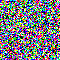

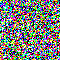

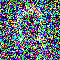

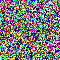

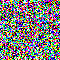

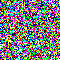

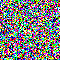

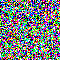

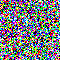

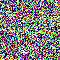

In [62]:
# plot the filters

wval = da.W.get_value(borrow=True)

for i in range(wval.shape[1]):
    col = wval[:, i]

    fil = col.reshape(old_shape)

    # Plot the filters
    image = Image.fromarray((fil * 255.0).astype('uint8'))

    b = BytesIO()
    image.save(b, format='png')
    disp.display(disp.Image(b.getvalue())) 

first image


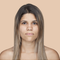

second image


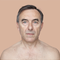

0.0


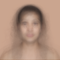

0.25


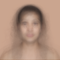

0.5


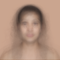

0.75


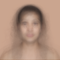

1.0


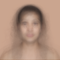

In [49]:
# Function for running the trained network
hiddens = da.get_hidden_values(xda)
reduce = th.function([xda], hiddens)

visibs = da.get_reconstructed_input(hiddens)
expand = th.function([hiddens], visibs)

# Sample two random images
im1 = data[random.randint(0, data.shape[0]-1), :] 
im2 = data[random.randint(0, data.shape[0]-1), :] 

# reduce 

h1 = reduce(im1.reshape((1, im1.shape[0])))
h2 = reduce(im2.reshape((1, im2.shape[0])))

print('first image')
vector = im1.reshape(old_shape) * 255.0 # flatten
vector = vector.astype('uint8')    # convert to integers

image = Image.fromarray(vector)    # convert to image

b = BytesIO()
image.save(b, format='png')
disp.display(disp.Image(b.getvalue())) 

print('second image')
vector = im2.reshape(old_shape) * 255.0 # flatten
vector = vector.astype('uint8')    # convert to integers

image = Image.fromarray(vector)    # convert to image

b = BytesIO()
image.save(b, format='png')
disp.display(disp.Image(b.getvalue())) 

inbetweens = 10

for a in np.linspace(0.0, 1.0, 5):
    print (a)
    
    h_mid = h2 * a + h1 * (1.0 - a)
    im_mid = expand(h_mid)
        
    vector = im_mid.reshape(old_shape) * 255.0 # flatten
    vector = vector.astype('uint8')    # convert to integers

    image = Image.fromarray(vector)    # convert to image

    b = BytesIO()
    image.save(b, format='png')
    disp.display(disp.Image(b.getvalue())) 



## Part 4: The _stacked_ denoising auto-encoder

In this part we will finally be doing some actual, proper deep learning. We will use the autoencoder of the last section to create a stacked autoencoder. Again, we will borrow heavily from the implementation at http://deeplearning.net/tutorial/SdA.html. 

In [16]:
# First we define a class representing a basic hidden layer
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        self.input = input

        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=th.config.floatX
            )
            if activation == th.tensor.nnet.sigmoid:
                W_values *= 4

            W = th.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=th.config.floatX)
            b = th.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]



# Now the class representing the stacked auto-encoder 
class SdA(object):
    def __init__(
        self,
        numpy_rng,
        input=input,
        theano_rng=None,
        n_ins=784,
        hidden_layers_sizes=[20000]
    ):
        self.sigmoid_layers = []
        self.dA_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0

        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))
            
        # allocate symbolic variables for the data
        self.x = input # the data is presented as rasterized images

        for i in range(self.n_layers):
                # construct the sigmoidal layer

                # the size of the input is either the number of hidden units of
                # the layer below or the input size if we are on the first layer
                if i == 0:
                    input_size = n_ins
                else:
                    input_size = hidden_layers_sizes[i - 1]

                # the input to this layer is either the activation of the hidden
                # layer below or the input of the SdA if you are on the first
                # layer
                if i == 0:
                    layer_input = self.x
                else:
                    layer_input = self.sigmoid_layers[-1].output

                sigmoid_layer = HiddenLayer(rng=numpy_rng,
                                            input=layer_input,
                                            n_in=input_size,
                                            n_out=hidden_layers_sizes[i],
                                            activation=T.nnet.sigmoid)
                # add the layer to our list of layers
                self.sigmoid_layers.append(sigmoid_layer)
                # its arguably a philosophical question...
                # but we are going to only declare that the parameters of the
                # sigmoid_layers are parameters of the StackedDAA
                # the visible biases in the dA are parameters of those
                # dA, but not the SdA
                self.params.extend(sigmoid_layer.params)

                # We re-use our da class, and give it the shared weight
                # matrix from this stacked autoencoder
                dA_layer = dA(numpy_rng=numpy_rng,
                              theano_rng=theano_rng,
                              input=layer_input,
                              n_visible=input_size,
                              n_hidden=hidden_layers_sizes[i],
                              W=sigmoid_layer.W,
                              bhid=sigmoid_layer.b)
                self.dA_layers.append(dA_layer)
                
    def pretraining_functions(self):
        ''' Returns training functions for each layer
        '''

        # index to a [mini]batch
        corruption_level = T.scalar('corruption')  # % of corruption to use
        learning_rate = T.scalar('lr')  # learning rate to use
        
        pretrain_fns = []
        for dA in self.dA_layers:
            # get the cost and the updates list
            cost, updates = dA.get_cost_updates(corruption_level,
                                                learning_rate)
            # compile the theano function
            fn = th.function(
                inputs=[
                    self.x,
                    th.In(corruption_level, value=0.01),
                    th.In(learning_rate, value=0.1)
                ],
                outputs=cost,
                updates=updates
            )
            # append `fn` to the list of functions
            pretrain_fns.append(fn)

        return pretrain_fns 
    
    def get_hidden_values(self, input):
        result = input
        for layer in self.dA_layers:
            result = layer.get_hidden_values(result)
        return result

    def get_reconstructed_input(self, hidden):
        result = hidden
        for layer in reversed(self.dA_layers):
            result = layer.get_reconstructed_input(result)
        return result
    

We can now build and train the model.

In [17]:
iterations = 10000
batch_size = 100
learning_rate = 0.01

numpy_rng = np.random.RandomState(89677)

x_sda = T.matrix('x_sda')

# construct the stacked denoising autoencoder class
sda = SdA(
    input=x_sda,
    numpy_rng=numpy_rng,
    n_ins= 60 * 60 * 3,
    hidden_layers_sizes=[10000]
)

pretraining_fns = sda.pretraining_functions()

# We train in the same way we did for the perceptron
for l in range(sda.n_layers):
    print('training layer {}'.format(l))
    for i in range(iterations):
        # select a mini-batch
        ix = np.random.randint(data.shape[0], size=batch_size)
        batch = data[ix, :]
    
        # perform the update
        error = pretraining_fns[l](batch)
    
        if i % 100 == 0:
            print('\titeration {}) error = {}'.format(i, error))

training layer 0
	iteration 0) error = 11607.175788086091
	iteration 100) error = 89179.15969594111
	iteration 200) error = 86589.57117371984
	iteration 300) error = 69859.05587347764
	iteration 400) error = 65626.58805651302
	iteration 500) error = 6864.456754011499
	iteration 600) error = 6752.912912981995
	iteration 700) error = 6911.557789535383
	iteration 800) error = 6769.925587114546


KeyboardInterrupt: 

Finally, we will use the same trick we used earlier to show how the network behaves.

first image


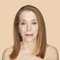

second image


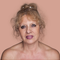

0.0


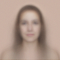

0.25


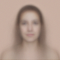

0.5


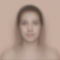

0.75


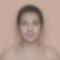

1.0


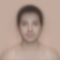

In [48]:
# Function for running the trained network
hiddens = sda.get_hidden_values(x_sda)
reduce = th.function([x_sda], hiddens)

visibs = sda.get_reconstructed_input(hiddens)
expand = th.function([hiddens], visibs)

# Sample two random images
im1 = data[random.randint(0, data.shape[0]-1), :] 
im2 = data[random.randint(0, data.shape[0]-1), :] 

# reduce 

h1 = reduce(im1.reshape((1, im1.shape[0])))
h2 = reduce(im2.reshape((1, im2.shape[0])))

print('first image')
vector = im1.reshape(old_shape) * 255.0 # flatten
vector = vector.astype('uint8')    # convert to integers

image = Image.fromarray(vector)    # convert to image

b = BytesIO()
image.save(b, format='png')
disp.display(disp.Image(b.getvalue())) 

print('second image')
vector = im2.reshape(old_shape) * 255.0 # flatten
vector = vector.astype('uint8')    # convert to integers

image = Image.fromarray(vector)    # convert to image

b = BytesIO()
image.save(b, format='png')
disp.display(disp.Image(b.getvalue())) 

inbetweens = 10

for a in np.linspace(0.0, 1.0, 5):
    print (a)
    
    h_mid = h2 * a + h1 * (1.0 - a)
    im_mid = expand(h_mid)
        
    vector = im_mid.reshape(old_shape) * 255.0 # flatten
    vector = vector.astype('uint8')    # convert to integers

    image = Image.fromarray(vector)    # convert to image

    b = BytesIO()
    image.save(b, format='png')
    disp.display(disp.Image(b.getvalue())) 

## Final notes

### GPU processing

We haven't optimized our code to run on the GPU, since we're all using our laptops anyway, but the advantage of using Theano is that the switch can be made very easily. Almost all of the work is done by theano under the hood: it simply compiles the computations we have defined for the GPU instead of the CPU. Still, some care must be taken to write code that runs well on the GPU. See http://deeplearning.net/software/theano/tutorial/using_gpu.html for more information.

## References
[1]: Assembled by Thomas Mensink, https://staff.fnwi.uva.nl/t.e.j.mensink/rijks/ <br/>
[2]: The Humanae project: http://humanae.tumblr.com/ by Angélica Dass. Note that I don't have permission to use these images (I think 60x60 thumbnails count as fair use), so do ask before you publish any derived works.